# Libraries

In [1]:
!pip install transformers==4.20.1 -U -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 1.12.1 requires huggingface-hub<0.1.0,>=0.0.14, but you have huggingface-hub 0.10.0 which is incompatible.
allennlp 2.7.0 requires transformers<4.10,>=4.1, but you have transformers 4.20.1 which is incompatible.


In [2]:
from transformers import CLIPProcessor, TFCLIPVisionModel, CLIPFeatureExtractor # TFCLIPModel
import re
import os
import glob
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime
import gc
import requests
from mpl_toolkits import axes_grid1

2022-10-02 14:37:39.077713: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-02 14:37:39.077834: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-02 14:37:45.718493: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-02 14:37:45.721143: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-02 14:37:45.721174: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-02 14:37:45.721202: I tensorflow/stream_executor/cuda/cud

# Device

In [3]:
# 启动TPU环境
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu) # 连接TPU集群
    tf.tpu.experimental.initialize_tpu_system(tpu) # 初始化TPU
    strategy = tf.distribute.TPUStrategy(tpu) # 创建TPU分布式策略
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE # 自动调整数据集参数
print("REPLICAS: ", strategy.num_replicas_in_sync) # 打印TPU个数

Running on TPU  grpc://10.0.0.2:8470


2022-10-02 14:37:46.183030: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-10-02 14:37:46.183095: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2022-10-02 14:37:46.206947: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-10-02 14:37:46.206999: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2022-10-02 14:37:46.207579: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30019


REPLICAS:  8


In [4]:
# If GPU instance, it makes mixed precision enable.
if strategy.num_replicas_in_sync == 1: # 如果是GPU实例，启用混合精度
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy) 

In [5]:
class config:
    SEED = 42

    # backbone model
    MODEL_NAME = "CLIP-ViT-H-14-laion2B-s32B-b79K" # 模型名称
    PRETRAINED_CLIP = f"laion/CLIP-ViT-H-14-laion2B-s32B-b79K" # 预训练模型

    PRETRAINED_CLIP_FROM_PT = True # 是否从PyTorch预训练模型转换而来
    INIT_WEIGHT = '../input/guie-clip-tf-train-models/model.H14-e100.h5' # 初始化权重
    IMAGE_SIZE = 224 # 图像尺寸

    # projection layer
    N_CLASSES = 17691 # 类别数
    EMB_DIM = 64 # embedding维度
    DROPOUT_RATE = 0. # dropout率
    
    # training
    TRAIN = True # 是否训练
    SHUFFLE = True # 是否打乱数据集
    AUGMENT = False # 是否增强数据集

    BATCH_SIZE = 25 * strategy.num_replicas_in_sync # batch大小
    EPOCHS = 10 # 训练轮数
    MAX_LR_PER_EXAMPLE = 1e-8 # 最大学习率
    MIN_LR_PER_EXAMPLE = 1e-9 # 最小学习率
    save_dir = "." # 保存路径

# 设置随机种子
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

CLIP-ViT-H-14-laion2B-s32B-b79K


# TFRecords

In [7]:
from kaggle_datasets import KaggleDatasets # 从Kaggle数据集中导入数据

train_shard_suffix = '*.tfrec' # 数据文件后缀

ROOT_DIRS  = [
    "guie-glr2021mini-tfrecords-label-10691-17690",
    "guie-imagenet1k-mini1-tfrecords-label-0-999",
    "guie-products10k-tfrecords-label-1000-10690",
]

train_set_path = []
valid_set_path = []
for ROOT_DIR in ROOT_DIRS:
    GCS_DS_PATH = KaggleDatasets().get_gcs_path( ROOT_DIR ) # 获取数据集路径 
        
    print( f"\"{ROOT_DIR}\" : \"{GCS_DS_PATH}\"," ) # 打印数据集路径
    files = sorted(tf.io.gfile.glob(GCS_DS_PATH + f'/{train_shard_suffix}')) # 获取数据文件列表
    assert len(files) > 0 # 确保数据文件列表不为空
    # split data
    train_set_path += random.sample(files, int( len(files) * 0.9 ) ) # 训练集
    valid_set_path += [ file for file in files  if not file in train_set_path ] # 验证集
    print(ROOT_DIR, ", number of tfrecords = ", len(files)) # 打印数据文件数量

train_set_path = sorted( train_set_path ) # 排序训练集
valid_set_path = sorted( valid_set_path ) # 排序验证集

print("# of tfrecords for training   : ", len(train_set_path)) # 打印训练集数量
print("# of tfrecords for validation : ", len(valid_set_path)) # 打印验证集数量

"guie-glr2021mini-tfrecords-label-10691-17690" : "gs://kds-31d5ada0f474669112699c448cb8759741c402ec75aedfe1fea6fdd6",
guie-glr2021mini-tfrecords-label-10691-17690 , number of tfrecords =  32


2022-10-02 14:37:52.769995: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


"guie-imagenet1k-mini1-tfrecords-label-0-999" : "gs://kds-8fe8ce5727babd9443ebe7b931902044eb3ca2eef9f1e5b769c8df09",
guie-imagenet1k-mini1-tfrecords-label-0-999 , number of tfrecords =  50


2022-10-02 14:37:53.219741: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


"guie-products10k-tfrecords-label-1000-10690" : "gs://kds-7fd5f627c770c661dc25919d7acd23e532bc1889c2953800e5112f10",
guie-products10k-tfrecords-label-1000-10690 , number of tfrecords =  20
# of tfrecords for training   :  91
# of tfrecords for validation :  11


2022-10-02 14:37:53.670087: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [8]:
def get_num_of_image(file):
    return int(file.split("/")[-1].split(".")[0].split("-")[-1]) # 根据数据文件中图片数量

train_set_len = sum( [ get_num_of_image(file) for file in train_set_path ] ) # 训练集图片数量
valid_set_len = sum( [ get_num_of_image(file) for file in valid_set_path ] ) # 验证集图片数量

train_set_len, valid_set_len

(478185, 62828)

# Dataset pipeline

In [9]:
# 解析 tfrecord
def deserialization_fn(serialized_example):
    parsed_example = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string), # 
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        }
    )
    image = tf.image.decode_jpeg(parsed_example['image/encoded'], channels=3)
    image = tf.image.resize(image, size=(config.IMAGE_SIZE, config.IMAGE_SIZE))
    label = tf.cast(parsed_example['image/class/label'], tf.int64)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [10]:
# Arcface 输入格式
def arcface_format(image, label_group):
    return {'inp1': image, 'inp2': label_group}, label_group

def rescale_image(image, label_group):
    image = tf.cast(image, tf.float32) * 255.0
    return image, label_group

# 数据增强
def data_augment(image, label_group):
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return image, label_group

# Dataset to obtain backbone's inference
def get_backbone_inference_dataset(tfrecord_paths, cache=False, repeat=False, shuffle=False, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices(tfrecord_paths) # 从tfrecord文件列表中创建数据集
    data_len = sum( [ get_num_of_image(file) for file in tfrecord_paths ] ) # 数据集图片数量
    if shuffle: 
        dataset = dataset.shuffle(len(tfrecord_paths)) # 打乱数据集
    dataset = dataset.flat_map(tf.data.TFRecordDataset) # 从tfrecord文件中读取数据
    dataset = dataset.map(deserialization_fn, num_parallel_calls=AUTO) # image[0-1], label[0-999] # 解析tfrecord
    if shuffle:
        dataset = dataset.shuffle(data_len//10) # 打乱数据集

    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)  # (image, label_group) --> (image, label_group)  # 数据增强
    dataset = dataset.map(rescale_image, num_parallel_calls = AUTO)  # image[0-1], label[0-n_classes] --> image[0-255], label[0-n_classes] # 重缩放
    dataset = dataset.map(arcface_format, num_parallel_calls=AUTO)   # (image, label_group) --> ({"inp1":image, "inp2":label_group}, label_group ) # Arcface 输入格式
    if repeat:
        dataset = dataset.repeat() # 重复数据集
    dataset = dataset.batch(config.BATCH_SIZE) # 批量处理
    dataset = dataset.prefetch(AUTO) # 预取数据
    return dataset

# Viz tfrecord images

(15, 224, 224, 3)


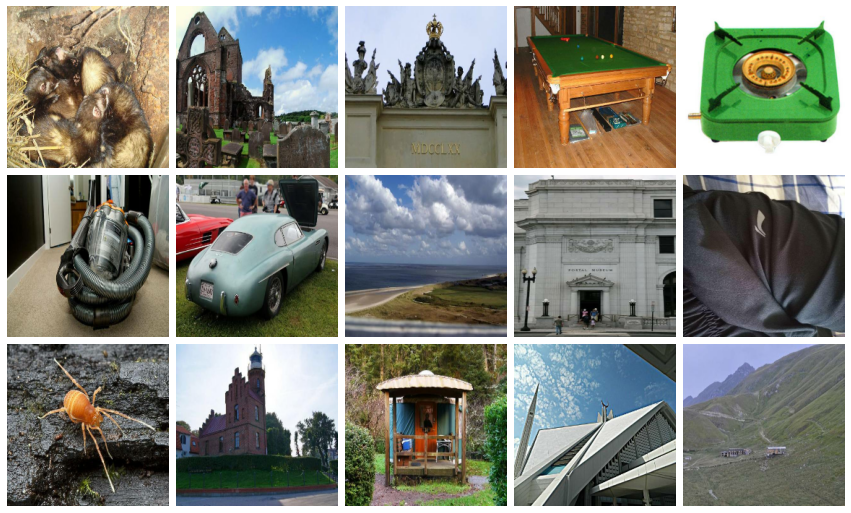

In [11]:
# 打印数据集图片示例
backbone_infer_dataset_encode = get_backbone_inference_dataset(train_set_path, shuffle=config.SHUFFLE, augment=config.AUGMENT) 

num_cols = 3
num_rows = 5
backbone_infer_dataset_encode = backbone_infer_dataset_encode.unbatch().batch(num_cols * num_rows)
x, y = next(iter(backbone_infer_dataset_encode))
print(x["inp1"].shape)

fig = plt.figure(figsize=(15, 15))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

for i, ax in enumerate(grid):
    ax.imshow(x["inp1"][i]/255)
    ax.axis("off")

del backbone_infer_dataset_encode

# Model

In [12]:
# Arcmarginproduct class keras layer ####
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)
        self.n_classes = n_classes # 类别数
        self.s = s # scale
        self.m = m # margin
        self.ls_eps = ls_eps # label smoothing
        self.easy_margin = easy_margin # easy_margin 模式
        self.cos_m = tf.math.cos(m) # cos margin
        self.sin_m = tf.math.sin(m) # sin margin
        self.th = tf.math.cos(math.pi - m) # cos(pi - m) = -cos(m)
        self.mm = tf.math.sin(math.pi - m) * m # sin(pi - m)*m = sin(m)*m

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])
        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        ) # 获得cosθ (vector)
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2)) # 获得cosθ
        phi = cosine * self.cos_m - sine * self.sin_m  # cosθ*cosm – sinθ*sinm = cos(θ + m)
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            # 以下代码控制了 θ+m 应该在 range[0, pi]
            # if cos(θ) > cos(pi - m) means θ + m < math.pi, so phi = cos(θ + m);
            # else means θ + m >= math.pi, we use Talyer extension to approximate the cos(θ + m).
            # if fact, cos(θ + m) = cos(θ) - m * sin(θ) >= cos(θ) - m * sin(math.pi - m)
            # https://github.com/ronghuaiyang/arcface-pytorch/issues/48
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        # 对label形式进行onehot转换，假设batch为2、有3类的话，即将label从[1,2]转换成[[0,1,0],[0,0,1]]
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        # label smoothing
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        # 进行re-scale
        output *= self.s
        return output

In [13]:
def get_scale_layer():
    '''
    图像归一化
    '''
    # For keras_cv_attention_models module:
    # ref: https://github.com/leondgarse/keras_cv_attention_models/blob/main/keras_cv_attention_models/imagenet/data.py
    # ref function : init_mean_std_by_rescale_mode()

    # For effV2 (21k classes) : https://github.com/leondgarse/keras_efficientnet_v2
    mean = np.array([0.485, 0.456, 0.406]) * 255.0
    std = np.array([0.229, 0.224, 0.225]) * 255.0
    scaling_layer = keras.layers.Lambda(lambda x: ( tf.cast(x, tf.float32) - mean) / std )
    return scaling_layer


def get_clip_model():
    '''
    获取CLIP模型
    '''
    inp = tf.keras.layers.Input(shape = [3, 224, 224]) # [B, C, H, W]
    backbone = TFCLIPVisionModel.from_pretrained(config.PRETRAINED_CLIP,
                                                 from_pt=config.PRETRAINED_CLIP_FROM_PT)
    output = backbone({'pixel_values':inp}).pooler_output
    return tf.keras.Model(inputs=[inp], outputs=[output])

def get_embedding_model():
    # 定义输入
    inp = tf.keras.layers.Input(shape = [None, None, 3], name = 'inp1') # 输入图像
    label = tf.keras.layers.Input(shape = (), name = 'inp2') # 标签

    # 定义层
    layer_resize = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, [config.IMAGE_SIZE, config.IMAGE_SIZE]), name='resize') # 图像resize
    layer_scaling = get_scale_layer() # 图像归一化
    layer_permute = tf.keras.layers.Permute((3,1,2)) # 图像通道转换
    layer_backbone = get_clip_model() # 获取CLIP模型
    layer_dropout = tf.keras.layers.Dropout(config.DROPOUT_RATE) # dropout
    layer_dense_before_arcface = tf.keras.layers.Dense(config.EMB_DIM) # 全连接层
    layer_margin = ArcMarginProduct(
        n_classes = config.N_CLASSES, # 类别数
        s = 30, # 缩放因子
        m = 0.3,  # margin
        name=f'head/arcface',
        dtype='float32'
        )
    layer_softmax = tf.keras.layers.Softmax(dtype='float32') # softmax
    layer_l2 = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1), name='embedding_norm') # l2归一化

    #------------------
    # 训练模型执行流程
    image = layer_scaling(inp) # 图像归一化
    image = layer_resize(image) # 图像resize
    image = layer_permute(image) # 图像通道转换
    backbone_output = layer_backbone(image) # 获取CLIP模型
    embed = layer_dropout(backbone_output) # dropout
    embed = layer_dense_before_arcface(embed) # 全连接层
    x = layer_margin([embed, label]) # arcface
    output = layer_softmax(x) # softmax
    model = tf.keras.models.Model(inputs = [inp, label], outputs = [output]) # 完整输入-输出结构

    opt = tf.keras.optimizers.Adam() # 优化器
    # 模型编译
    model.compile(
        optimizer = opt, # 优化器
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()], # loss
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)] # 评价指标
        )

    #------------------
    # embedding模型执行流程（用作提交）
    embed_model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(None, None, 3), dtype='uint8'),  # 图像输入
        layer_scaling, # 图像归一化
        layer_resize, # 图像resize
        layer_permute, # 图像通道转换
        layer_backbone, # 获取CLIP模型
        layer_dropout, # dropout
        layer_dense_before_arcface, # 全连接层
        layer_l2, # l2归一化
    ])

    return model, embed_model

In [14]:
with strategy.scope():
    model, emb_model = get_embedding_model() # get model

model.load_weights(config.INIT_WEIGHT) # load weight

Downloading:   0%|          | 0.00/4.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCLIPVisionModel: ['text_model.encoder.layers.9.layer_norm2.weight', 'text_model.encoder.layers.14.self_attn.out_proj.bias', 'text_model.encoder.layers.12.layer_norm2.bias', 'text_model.encoder.layers.20.mlp.fc1.weight', 'text_model.encoder.layers.18.mlp.fc1.weight', 'text_model.encoder.layers.16.mlp.fc2.weight', 'text_model.encoder.layers.4.self_attn.v_proj.weight', 'text_model.encoder.layers.8.self_attn.v_proj.bias', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.18.mlp.fc2.bias', 'text_model.encoder.layers.1.layer_norm2.weight', 'text_model.encoder.layers.21.self_attn.q_proj.bias', 'text_model.encoder.layers.23.self_attn.k_proj.bias', 'text_model.encoder.layers.8.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.v_proj.bias', 'text_model.encoder.layers.16.layer_norm2.bias', 'text_model.encoder.layers.22.self_attn.k_proj.weight', 'text_model.encoder.layers.5.

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, None, 3 0           inp1[0][0]                       
__________________________________________________________________________________________________
resize (Lambda)                 (None, 224, 224, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
permute (Permute)               (None, 3, 224, 224)  0           resize[0][0]                     
____________________________________________________________________________________________

In [16]:
emb_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, None, 3)     0         
_________________________________________________________________
resize (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
permute (Permute)            (None, 3, 224, 224)       0         
_________________________________________________________________
model (Functional)           (None, 1280)              630766080 
_________________________________________________________________
dropout_32 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
embedding_norm (Lambda)      (None, 64)                0

# Scheduler

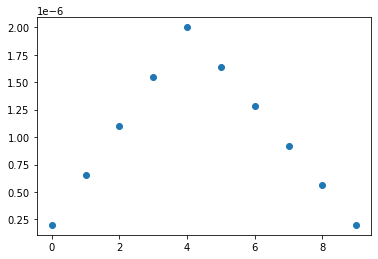

In [17]:
# 调度器调整学习率
def get_lr_callback(plot=False):
    lr_start   = config.MIN_LR_PER_EXAMPLE * config.BATCH_SIZE # 初始学习率
    lr_max     = config.MAX_LR_PER_EXAMPLE * config.BATCH_SIZE # 最大学习率
    lr_min     = config.MIN_LR_PER_EXAMPLE * config.BATCH_SIZE # 最小学习率
    lr_ramp_ep = 4 # 
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start # 升温
        else:
            lr = (lr_max - lr_min) * (config.EPOCHS - epoch - 1) / (config.EPOCHS - lr_ramp_ep - 1) + lr_min # 线性减小
        return lr
        
    if plot: # 作图
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False) # keras lr调度器
    return lr_callback

get_lr_callback(plot=True) # 定义调度器

# Train entire model 

In [18]:
if config.TRAIN:
    sv_loss = tf.keras.callbacks.ModelCheckpoint(
        config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_loss.h5", # 保存地址
        monitor='val_sparse_categorical_accuracy', # 评价指标
        verbose=1,  # 打印结果
        save_best_only=True, # 仅保存最好的一个模型
        save_weights_only=True,  # 仅保存权重值
        mode='max', # 评价指标 最大值最优
        save_freq='epoch' # 保存频率epoch
        )

    steps_per_epoch = train_set_len // config.BATCH_SIZE  // 10     # "//10" means that the lr is update every 0.1 epoch.
    validation_steps = valid_set_len // config.BATCH_SIZE # 验证频率
    if valid_set_len % config.BATCH_SIZE != 0:
        validation_steps += 1
    print(steps_per_epoch, validation_steps) # 
    ds_train = get_backbone_inference_dataset(train_set_path, shuffle=config.SHUFFLE, augment=config.AUGMENT, repeat=True) # 训练集
    ds_valid = get_backbone_inference_dataset(valid_set_path, shuffle=False, augment=False, repeat=False) # 验证集
    # 模型训练
    history = model.fit(
        ds_train, # 训练集
        epochs=config.EPOCHS, # epoch
        callbacks=[get_lr_callback(), sv_loss], # callback
        steps_per_epoch=steps_per_epoch, # 迭代次数
        validation_data = ds_valid, # 验证集
        validation_steps = validation_steps, # 验证次数
        verbose=1 # 打印结果
    ) 

    # load best weight
    model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_loss.h5")

239 315
Epoch 1/10
239/239 [==============================] - 745s 2s/step - loss: 4.3184 - sparse_categorical_accuracy: 0.3171 - sparse_top_k_categorical_accuracy: 0.5384 - val_loss: 3.9398 - val_sparse_categorical_accuracy: 0.3492 - val_sparse_top_k_categorical_accuracy: 0.5732

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.34919, saving model to ./CLIP-ViT-H-14-laion2B-s32B-b79K_224pix-emb64_loss.h5
Epoch 2/10
239/239 [==============================] - 446s 2s/step - loss: 4.2439 - sparse_categorical_accuracy: 0.3215 - sparse_top_k_categorical_accuracy: 0.5440 - val_loss: 3.8345 - val_sparse_categorical_accuracy: 0.3607 - val_sparse_top_k_categorical_accuracy: 0.5858

Epoch 00002: val_sparse_categorical_accuracy improved from 0.34919 to 0.36065, saving model to ./CLIP-ViT-H-14-laion2B-s32B-b79K_224pix-emb64_loss.h5
Epoch 3/10
239/239 [==============================] - 446s 2s/step - loss: 3.8854 - sparse_categorical_accuracy: 0.3583 - sparse_top_k_categorical_

In [19]:
# 保存最好的embedding 模型
emb_model.save_weights( config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_emb_model.h5" ) 

# Create submission.zip

In [20]:
# 打包embedding模型, 提交结果
save_locally = tf.saved_model.SaveOptions(
    experimental_io_device='/job:localhost'
)
emb_model.save('./embedding_norm_model', options=save_locally)

from zipfile import ZipFile

with ZipFile('submission.zip','w') as zip:           
    zip.write(
        './embedding_norm_model/saved_model.pb', 
        arcname='saved_model.pb'
    ) 
    zip.write(
        './embedding_norm_model/variables/variables.data-00000-of-00001', 
        arcname='variables/variables.data-00000-of-00001'
    ) 
    zip.write(
        './embedding_norm_model/variables/variables.index', 
        arcname='variables/variables.index'
    )

2022-10-02 16:04:02.652359: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
